In [1]:
import janitor
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from forestplot import forestplot

from utilities.graph_utils import save_mpl_fig
from utilities.utils import get_fulldata, pandas_to_tex

plt.rcParams["font.monospace"] = ["Noto Mono", "Tlwg Mono", "Courier New"]
import matplotlib.ticker as mtick
import seaborn as sns

sns.set_theme(
    context="notebook", font_scale=1.5, style="whitegrid", palette="dark"
)  #  Darkgrid Whitegrid Dark White Ticks

import warnings

warnings.filterwarnings("ignore")

usecols = ["account_no", "6", "7", "8"]
df = (
    get_fulldata(usecols=usecols, low_memory=False)
    .rename_columns(new_column_names={"6": "acres", "7": "decimals", "8": "hectare"})
    .query("decimals >= 0 & decimals <= 99")
    .assign(tt_area_acre=lambda df_: df_["acres"] + df_["decimals"] / 100)
    .query("tt_area_acre>0")
)
print(df.shape)
display(df.head())
df.info(show_counts=True)

(38589908, 5)


,account_no,acres,decimals,hectare,tt_area_acre
0,1801010001000002,0.0,66.0,0.0,0.66
1,1801010001000002,0.0,8.0,0.0,0.08
2,1801010001000002,0.0,6.0,0.0,0.06
3,1801010001000002,0.0,3.0,0.0,0.03
4,1801010001000002,0.0,36.0,0.0,0.36


<class 'pandas.core.frame.DataFrame'>
Index: 38589908 entries, 0 to 41871024
Data columns (total 5 columns):
 #   Column        Non-Null Count     Dtype  
---  ------        --------------     -----  
 0   account_no    38589908 non-null  int64  
 1   acres         38589908 non-null  float64
 2   decimals      38589908 non-null  float64
 3   hectare       38589908 non-null  float64
 4   tt_area_acre  38589908 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.7 GB


In [2]:
df["account_no"].nunique()

11904901

### Prep intermediate data for number of plots and area of plots

In [3]:
nplots_by_account = (
    df.groupby("account_no").size().reset_index().rename_column(0, "nplots")
)
print(f"{len(nplots_by_account)=:,}")
print(nplots_by_account.head(3))

len(nplots_by_account)=11,904,901
        account_no  nplots
0  101010273000001       2
1  101010273000002       8
2  101010273000003       1


In [4]:
landarea_by_account = (
    df.groupby("account_no").sum().reset_index().query("tt_area_acre>0")
)
print(f"{len(landarea_by_account)=:,}")
print(landarea_by_account.head(3))

len(landarea_by_account)=11,904,901
        account_no  acres  decimals  hectare  tt_area_acre
0  101010273000001    0.0      58.5      0.0         0.585
1  101010273000002    0.0     154.5      0.0         1.545
2  101010273000003    0.0       8.0      0.0         0.080


### Skew in Number of plots per account holder

In [5]:
# Get table of percentiles (fold cell)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
    1,
]
tab_nplot_deciles = (
    nplots_by_account.nplots.quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .astype({"nplots": int})
)
pandas_to_tex(
    tab_nplot_deciles,
    "../tables/percentiles_landplots_per_accountholder",
    float_format="%.2f",
)
tab_nplot_deciles

,Percentile,nplots
0,0.00,1
1,0.10,1
2,0.20,1
3,0.30,1
4,0.40,1
5,0.50,1
6,0.60,1
7,0.70,2
8,0.80,3
9,0.90,7


In [6]:
std_opts_displot = dict(
    color="0.3",
    aspect=1.5,
    height=6,
)

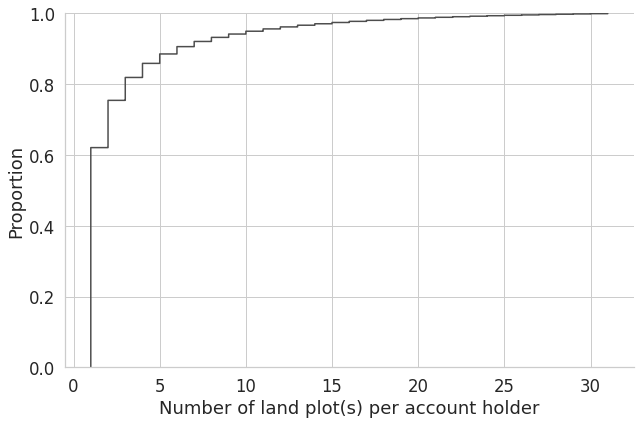

In [7]:
# Empirical CDF of #plots owned per account (fold cell)
sns.displot(
    x="nplots",
    data=nplots_by_account.query(f"nplots<={nplots_by_account.nplots.quantile(.99)}"),
    kind="ecdf",
    **std_opts_displot,
)
plt.xlabel("Number of land plot(s) per account holder")
save_mpl_fig("../figures/number_plots_per_accountholder_ecdf")

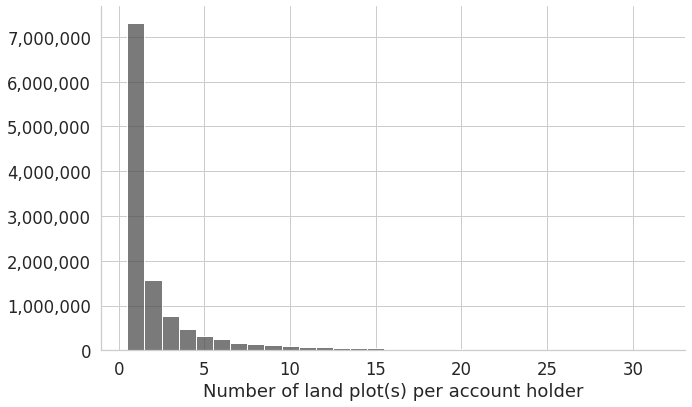

In [8]:
# Histogram of #plots owned per account (fold cell)
ax = sns.displot(
    data=nplots_by_account.query(f"nplots<={nplots_by_account.nplots.quantile(.99)}"),
    x="nplots",
    kind="hist",
    discrete=True,
    **std_opts_displot,
)
ax.set_xlabels("Number of land plot(s) per account holder")
ax.set_ylabels("")
# https://stackoverflow.com/questions/39376888/how-to-separate-thousands-with-commas-using-facet-grid-in-seaborn
for _ax in ax.axes[:, 0]:
    _ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
save_mpl_fig("../figures/number_plots_per_accountholder_histogram")

### Skew in area of plot(s) owned per account holder

In [9]:
# Get table of percentiles (fold cell)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
    1,
]
tab_acres_deciles = (
    landarea_by_account.tt_area_acre.quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .round(decimals=2)
)
pandas_to_tex(
    tab_acres_deciles,
    "../tables/percentiles_landarea_per_accountholder",
    float_format="%.2f",
)
tab_acres_deciles

,Percentile,tt_area_acre
0,0.00,0.00
1,0.10,0.03
2,0.20,0.07
3,0.30,0.13
4,0.40,0.21
5,0.50,0.32
6,0.60,0.49
7,0.70,0.75
8,0.80,1.21
9,0.90,2.42


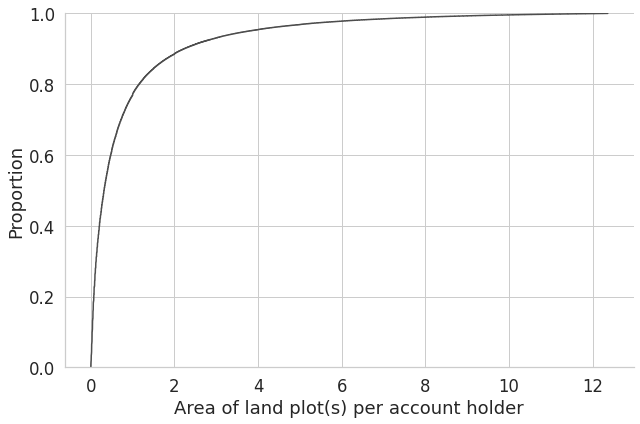

In [10]:
# Empirical CDF of land plot area owned per account (fold cell)
sns.displot(
    x="tt_area_acre",
    data=landarea_by_account.query(
        f"tt_area_acre<={landarea_by_account.tt_area_acre.quantile(.99)}"
    ),
    kind="ecdf",
    **std_opts_displot,
)
plt.xlabel("Area of land plot(s) per account holder")
save_mpl_fig("../figures/plot_area_per_accountholder_ecdf")

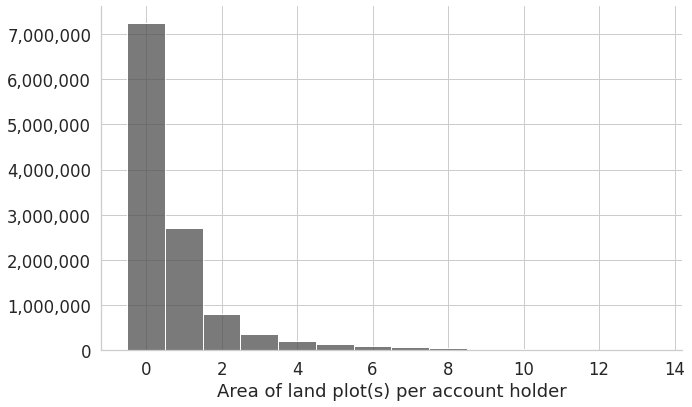

In [11]:
# Histogram of land plot area owned per account (fold cell)
ax = sns.displot(
    data=landarea_by_account.query(
        f"tt_area_acre<={landarea_by_account.tt_area_acre.quantile(.99)}"
    ),
    x="tt_area_acre",
    kind="hist",
    discrete=True,
    **std_opts_displot,
)
ax.set_xlabels("Area of land plot(s) per account holder")
ax.set_ylabels("")
# https://stackoverflow.com/questions/39376888/how-to-separate-thousands-with-commas-using-facet-grid-in-seaborn
for _ax in ax.axes[:, 0]:
    _ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
save_mpl_fig("../figures/plot_area_per_accountholder_histogram")

### Skew in area per plot owned per account holder

In [12]:
df_land_per_plot = landarea_by_account.merge(
    nplots_by_account, how="left", on=["account_no"], validate="1:1"
).assign(land_per_plot=lambda df: df.tt_area_acre / df.nplots)
df_land_per_plot.head(3)

,account_no,acres,decimals,hectare,tt_area_acre,nplots,land_per_plot
0,101010273000001,0.0,58.5,0.0,0.585,2,0.292500
1,101010273000002,0.0,154.5,0.0,1.545,8,0.193125
2,101010273000003,0.0,8.0,0.0,0.080,1,0.080000


In [13]:
# Get table of percentiles (fold cell)
ntiles = [
    0.0,
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9,
    0.95,
    0.96,
    0.97,
    0.98,
    0.99,
    1,
]
tab_acresperplot_deciles = (
    df_land_per_plot.land_per_plot.quantile(ntiles)
    .reset_index()
    .rename_column("index", "Percentile")
    .round(decimals=2)
)
pandas_to_tex(
    tab_acresperplot_deciles,
    "../tables/percentiles_landarea_per_plot_per_accountholder",
    float_format="%.2f",
)
tab_acresperplot_deciles

,Percentile,land_per_plot
0,0.00,0.00
1,0.10,0.03
2,0.20,0.06
3,0.30,0.09
4,0.40,0.13
5,0.50,0.18
6,0.60,0.25
7,0.70,0.34
8,0.80,0.51
9,0.90,0.92


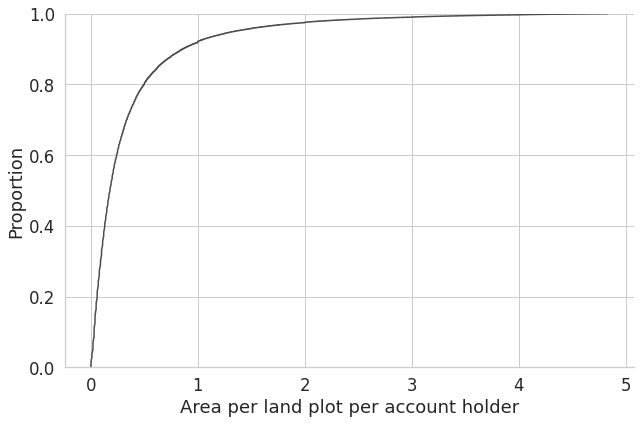

In [14]:
# Empirical CDF of land per area owned per account (fold cell)
sns.displot(
    x="land_per_plot",
    data=df_land_per_plot.query(
        f"land_per_plot<={df_land_per_plot.land_per_plot.quantile(.99)}"
    ),
    kind="ecdf",
    **std_opts_displot,
)
plt.xlabel("Area per land plot per account holder")
save_mpl_fig("../figures/landarea_per_plot_per_accountholder_ecdf")

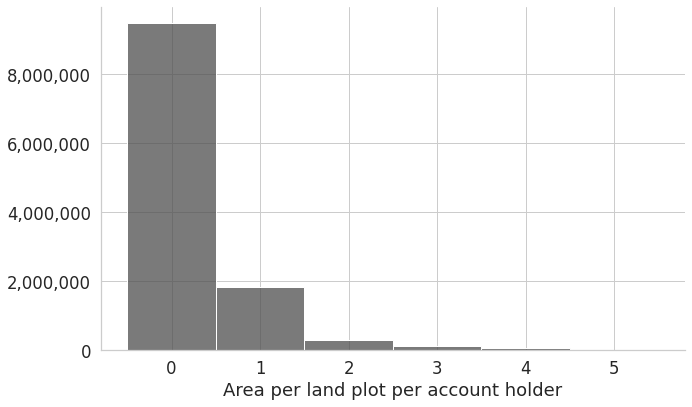

In [15]:
# Histogram of land plot area owned per account (fold cell)
ax = sns.displot(
    data=df_land_per_plot.query(
        f"land_per_plot<={df_land_per_plot.land_per_plot.quantile(.99)}"
    ),
    x="land_per_plot",
    kind="hist",
    discrete=True,
    **std_opts_displot,
)
ax.set_xlabels("Area per land plot per account holder")
ax.set_ylabels("")
# https://stackoverflow.com/questions/39376888/how-to-separate-thousands-with-commas-using-facet-grid-in-seaborn
for _ax in ax.axes[:, 0]:
    _ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter("{x:,.0f}"))
save_mpl_fig("../figures/landarea_per_plot_per_accountholder_histogram")

### Common last names of land owners in registry

In [16]:
HINDI_NAMES = "../data/hindi_names_religion.csv.gz"

df_name = (
    pd.read_csv("../data/hindi_names_religion_translated.csv.gz")
    .dropna(subset="eng_name")
    .assign(last_name=lambda df: [name.split(" ")[-1].title() for name in df.eng_name])
    .groupby(["last_name", "pred_label"])
    .size()
    .reset_index()
    .rename_column(0, "count")
    .sort_values("count", ascending=False, ignore_index=True)
    .assign(pred_label=lambda df: df.pred_label.str.title())
    .assign(count_str=lambda df: df.apply(lambda x: "{:,}".format(x["count"]), axis=1))
    .assign(
        count_str=lambda df: df.count_str.apply(
            lambda x: x.rjust(7) if len(x) < 7 else x
        )
    )
    .assign(
        pred_label=lambda df: np.where(
            df.pred_label == "Not-Muslim", "Non-Muslim", df.pred_label
        )
    )
    .assign(
        pred_label=lambda df: df.pred_label.apply(
            lambda x: x.rjust(10) if len(x) < 10 else x
        )
    )
)
df_name.head(30)

,last_name,pred_label,count,count_str
0,Devi,Non-Muslim,172507,"172,507"
1,Singh,Non-Muslim,121827,"121,827"
2,Yadavas,Non-Muslim,113381,"113,381"
3,Siha,Non-Muslim,68161,"68,161"
4,Sah,Non-Muslim,66308,"66,308"
5,Ray,Non-Muslim,64250,"64,250"
6,Mahato,Non-Muslim,62392,"62,392"
7,Mandal,Non-Muslim,60880,"60,880"
8,Khatun,Muslim,38940,"38,940"
9,Thakur,Non-Muslim,35708,"35,708"


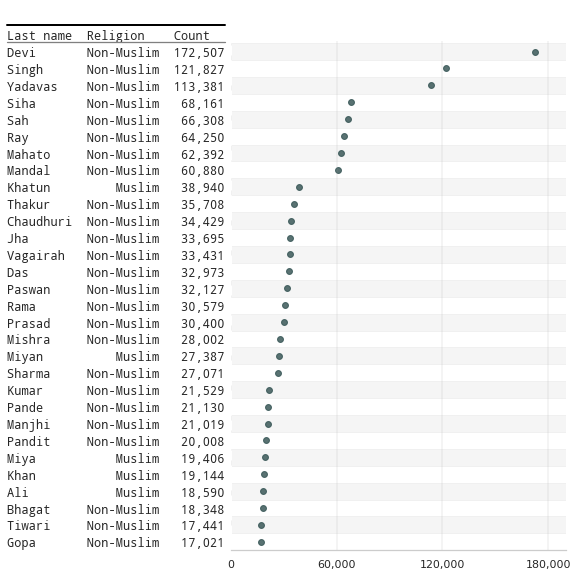

In [17]:
# Plot (fold cell)
ax = forestplot(
    df_name.head(30),
    estimate="count",
    varlabel="last_name",
    xticks=[0, 60_000, 120_000, 180_000],
    annote=["pred_label", "count_str"],
    annoteheaders=["Religion", "Count"],
    ci_report=False,
    figsize=(6, 10),
    color_alt_rows=True,
    table=True,
    **{
        "marker": "o",  # set maker symbol as diamond
        "variable_header": "Last name",
        "markersize": 35,  # adjust marker size
        "xlinestyle": (0, (10, 5)),  # long dash for x-reference line
        "xlinecolor": "1",  # gray color for x-reference line
        "xtick_size": 11,  # adjust x-ticker fontsize
    },
)
ax.xaxis.set_ticks_position("none")
ax.grid(False)
fmt = "{x:,.0f}"
tick = mtick.StrMethodFormatter(fmt)
ax.xaxis.set_major_formatter(tick)
for vline in [60_000, 120_000, 180_000]:
    ax.vlines(vline, ymin=-0.5, ymax=29.6, colors=".6", linewidth=0.2)
save_mpl_fig("../figures/30_most_common_lastnames_accountholders")

In [18]:
# import winsound
# frequency = 2500  # Set Frequency To 2500 Hertz
# duration = 1000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)